In [1]:
"""ZHIPU AI chat models wrapper."""
from __future__ import annotations

import asyncio
import logging
from functools import partial
from importlib.metadata import version
from typing import (
    Any,
    Callable,
    Dict,
    Iterator,
    List,
    Mapping,
    Optional,
    Tuple,
    Type,
    Union,
)

from langchain_core.callbacks import (
    AsyncCallbackManagerForLLMRun,
    CallbackManagerForLLMRun,
)
from langchain_core.language_models.chat_models import (
    BaseChatModel,
    generate_from_stream,
)
from langchain_core.language_models.llms import create_base_retry_decorator
from langchain_core.messages import (
    AIMessage,
    AIMessageChunk,
    BaseMessage,
    BaseMessageChunk,
    ChatMessage,
    ChatMessageChunk,
    HumanMessage,
    HumanMessageChunk,
    SystemMessage,
    SystemMessageChunk,
    ToolMessage,
    ToolMessageChunk,
)
from langchain_core.outputs import (
    ChatGeneration,
    ChatGenerationChunk,
    ChatResult,
)
from langchain_core.pydantic_v1 import BaseModel, Field
from packaging.version import parse

logger = logging.getLogger(__name__)


def is_zhipu_v2() -> bool:
    """Return whether zhipu API is v2 or more."""
    _version = parse(version("zhipuai"))
    return _version.major >= 2


def _create_retry_decorator(
    llm: ChatZhipuAI,
    run_manager: Optional[
        Union[AsyncCallbackManagerForLLMRun, CallbackManagerForLLMRun]
    ] = None,
) -> Callable[[Any], Any]:
    import zhipuai

    errors = [
        zhipuai.ZhipuAIError,
        zhipuai.APIStatusError,
        zhipuai.APIRequestFailedError,
        zhipuai.APIReachLimitError,
        zhipuai.APIInternalError,
        zhipuai.APIServerFlowExceedError,
        zhipuai.APIResponseError,
        zhipuai.APIResponseValidationError,
        zhipuai.APITimeoutError,
    ]
    return create_base_retry_decorator(
        error_types=errors, max_retries=llm.max_retries, run_manager=run_manager
    )


def convert_message_to_dict(message: BaseMessage) -> dict:
    """Convert a LangChain message to a dictionary.

    Args:
        message: The LangChain message.

    Returns:
        The dictionary.
    """
    message_dict: Dict[str, Any]
    if isinstance(message, ChatMessage):
        message_dict = {"role": message.role, "content": message.content}
    elif isinstance(message, HumanMessage):
        message_dict = {"role": "user", "content": message.content}
    elif isinstance(message, AIMessage):
        message_dict = {"role": "assistant", "content": message.content}
        if "tool_calls" in message.additional_kwargs:
            message_dict["tool_calls"] = message.additional_kwargs["tool_calls"]
            # If tool calls only, content is None not empty string
            if message_dict["content"] == "":
                message_dict["content"] = None
    elif isinstance(message, SystemMessage):
        message_dict = {"role": "system", "content": message.content}
    elif isinstance(message, ToolMessage):
        message_dict = {
            "role": "tool",
            "content": message.content,
            "tool_call_id": message.tool_call_id,
        }
    else:
        raise TypeError(f"Got unknown type {message}")
    if "name" in message.additional_kwargs:
        message_dict["name"] = message.additional_kwargs["name"]
    return message_dict


def convert_dict_to_message(_dict: Mapping[str, Any]) -> BaseMessage:
    """Convert a dictionary to a LangChain message.

    Args:
        _dict: The dictionary.

    Returns:
        The LangChain message.
    """
    role = _dict.get("role")
    if role == "user":
        return HumanMessage(content=_dict.get("content", ""))
    elif role == "assistant":
        content = _dict.get("content", "") or ""
        additional_kwargs: Dict = {}
        if tool_calls := _dict.get("tool_calls"):
            additional_kwargs["tool_calls"] = tool_calls
        return AIMessage(content=content, additional_kwargs=additional_kwargs)
    elif role == "system":
        return SystemMessage(content=_dict.get("content", ""))
    elif role == "tool":
        additional_kwargs = {}
        if "name" in _dict:
            additional_kwargs["name"] = _dict["name"]
        return ToolMessage(
            content=_dict.get("content", ""),
            tool_call_id=_dict.get("tool_call_id"),
            additional_kwargs=additional_kwargs,
        )
    else:
        return ChatMessage(content=_dict.get("content", ""), role=role)


def _convert_delta_to_message_chunk(
    _dict: Mapping[str, Any], default_class: Type[BaseMessageChunk]
) -> BaseMessageChunk:
    role = _dict.get("role")
    content = _dict.get("content") or ""
    additional_kwargs: Dict = {}
    if _dict.get("tool_calls"):
        additional_kwargs["tool_calls"] = _dict["tool_calls"]

    if role == "user" or default_class == HumanMessageChunk:
        return HumanMessageChunk(content=content)
    elif role == "assistant" or default_class == AIMessageChunk:
        return AIMessageChunk(content=content, additional_kwargs=additional_kwargs)
    elif role == "system" or default_class == SystemMessageChunk:
        return SystemMessageChunk(content=content)
    elif role == "tool" or default_class == ToolMessageChunk:
        return ToolMessageChunk(content=content, tool_call_id=_dict["tool_call_id"])
    elif role or default_class == ChatMessageChunk:
        return ChatMessageChunk(content=content, role=role)
    else:
        return default_class(content=content)


class ChatZhipuAI(BaseChatModel):
    """
    `ZHIPU AI` large language chat models API.

    To use, you should have the ``zhipuai`` python package installed.

    Example:
    .. code-block:: python

    from langchain_community.chat_models import ChatZhipuAI

    zhipuai_chat = ChatZhipuAI(
        temperature=0.5,
        api_key="your-api-key",
        model_name="glm-3-turbo",
    )

    """

    zhipuai: Any
    zhipuai_api_key: Optional[str] = Field(default=None, alias="api_key")
    """Automatically inferred from env var `ZHIPUAI_API_KEY` if not provided."""

    client: Any = Field(default=None, exclude=True)  #: :meta private:

    model_name: str = Field("glm-3-turbo", alias="model")
    """
    Model name to use.
    -glm-3-turbo:
        According to the input of natural language instructions to complete a
        variety of language tasks, it is recommended to use SSE or asynchronous
        call request interface.
    -glm-4:
        According to the input of natural language instructions to complete a
        variety of language tasks, it is recommended to use SSE or asynchronous
        call request interface.
    """

    temperature: float = Field(0.95)
    """
    What sampling temperature to use. The value ranges from 0.0 to 1.0 and cannot
    be equal to 0.
    The larger the value, the more random and creative the output; The smaller
    the value, the more stable or certain the output will be.
    You are advised to adjust top_p or temperature parameters based on application
    scenarios, but do not adjust the two parameters at the same time.
    """

    top_p: float = Field(0.7)
    """
    Another method of sampling temperature is called nuclear sampling. The value
    ranges from 0.0 to 1.0 and cannot be equal to 0 or 1.
    The model considers the results with top_p probability quality tokens.
    For example, 0.1 means that the model decoder only considers tokens from the
    top 10% probability of the candidate set.
    You are advised to adjust top_p or temperature parameters based on application
    scenarios, but do not adjust the two parameters at the same time.
    """

    request_id: Optional[str] = Field(None)
    """
    Parameter transmission by the client must ensure uniqueness; A unique
    identifier used to distinguish each request, which is generated by default
    by the platform when the client does not transmit it.
    """
    do_sample: Optional[bool] = Field(True)
    """
    When do_sample is true, the sampling policy is enabled. When do_sample is false,
    the sampling policy temperature and top_p are disabled
    """
    streaming: bool = Field(False)
    """Whether to stream the results or not."""

    model_kwargs: Dict[str, Any] = Field(default_factory=dict)
    """Holds any model parameters valid for `create` call not explicitly specified."""

    max_tokens: Optional[int] = None
    """Number of chat completions to generate for each prompt."""

    max_retries: int = 2
    """Maximum number of retries to make when generating."""

    @property
    def _identifying_params(self) -> Dict[str, Any]:
        """Get the identifying parameters."""
        return {**{"model_name": self.model_name}, **self._default_params}

    @property
    def _llm_type(self) -> str:
        """Return the type of chat model."""
        return "zhipuai"

    @property
    def lc_secrets(self) -> Dict[str, str]:
        return {"zhipuai_api_key": "ZHIPUAI_API_KEY"}

    @classmethod
    def get_lc_namespace(cls) -> List[str]:
        """Get the namespace of the langchain object."""
        return ["langchain", "chat_models", "zhipuai"]

    @property
    def lc_attributes(self) -> Dict[str, Any]:
        attributes: Dict[str, Any] = {}

        if self.model_name:
            attributes["model"] = self.model_name

        if self.streaming:
            attributes["streaming"] = self.streaming

        if self.max_tokens:
            attributes["max_tokens"] = self.max_tokens

        return attributes

    @property
    def _default_params(self) -> Dict[str, Any]:
        """Get the default parameters for calling ZhipuAI API."""
        params = {
            "model": self.model_name,
            "stream": self.streaming,
            "temperature": self.temperature,
            "top_p": self.top_p,
            "do_sample": self.do_sample,
            **self.model_kwargs,
        }
        if self.max_tokens is not None:
            params["max_tokens"] = self.max_tokens
        return params

    @property
    def _client_params(self) -> Dict[str, Any]:
        """Get the parameters used for the zhipuai client."""
        zhipuai_creds: Dict[str, Any] = {
            "request_id": self.request_id,
        }
        return {**self._default_params, **zhipuai_creds}

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        try:
            from zhipuai import ZhipuAI

            if not is_zhipu_v2():
                raise RuntimeError(
                    "zhipuai package version is too low"
                    "Please install it via 'pip install --upgrade zhipuai'"
                )

            self.client = ZhipuAI(
                api_key=self.zhipuai_api_key,  # 填写您的 APIKey
            )
        except ImportError:
            raise RuntimeError(
                "Could not import zhipuai package. "
                "Please install it via 'pip install zhipuai'"
            )

    def completions(self, **kwargs) -> Any | None:
        return self.client.chat.completions.create(**kwargs)

    async def async_completions(self, **kwargs) -> Any:
        loop = asyncio.get_running_loop()
        partial_func = partial(self.client.chat.completions.create, **kwargs)
        response = await loop.run_in_executor(
            None,
            partial_func,
        )
        return response

    async def async_completions_result(self, task_id):
        loop = asyncio.get_running_loop()
        response = await loop.run_in_executor(
            None,
            self.client.asyncCompletions.retrieve_completion_result,
            task_id,
        )
        return response

    def _create_chat_result(self, response: Union[dict, BaseModel]) -> ChatResult:
        generations = []
        if not isinstance(response, dict):
            response = response.dict()
        for res in response["choices"]:
            message = convert_dict_to_message(res["message"])
            generation_info = dict(finish_reason=res.get("finish_reason"))
            if "index" in res:
                generation_info["index"] = res["index"]
            gen = ChatGeneration(
                message=message,
                generation_info=generation_info,
            )
            generations.append(gen)
        token_usage = response.get("usage", {})
        llm_output = {
            "token_usage": token_usage,
            "model_name": self.model_name,
            "task_id": response.get("id", ""),
            "created_time": response.get("created", ""),
        }
        return ChatResult(generations=generations, llm_output=llm_output)

    def _create_message_dicts(
        self, messages: List[BaseMessage], stop: Optional[List[str]]
    ) -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:
        params = self._client_params
        if stop is not None:
            if "stop" in params:
                raise ValueError("`stop` found in both the input and default params.")
            params["stop"] = stop
        message_dicts = [convert_message_to_dict(m) for m in messages]
        return message_dicts, params

    def completion_with_retry(
        self, run_manager: Optional[CallbackManagerForLLMRun] = None, **kwargs: Any
    ) -> Any:
        """Use tenacity to retry the completion call."""

        retry_decorator = _create_retry_decorator(self, run_manager=run_manager)

        @retry_decorator
        def _completion_with_retry(**kwargs: Any) -> Any:
            return self.completions(**kwargs)

        return _completion_with_retry(**kwargs)

    async def acompletion_with_retry(
        self,
        run_manager: Optional[AsyncCallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> Any:
        """Use tenacity to retry the async completion call."""

        retry_decorator = _create_retry_decorator(self, run_manager=run_manager)

        @retry_decorator
        async def _completion_with_retry(**kwargs: Any) -> Any:
            return await self.async_completions(**kwargs)

        return await _completion_with_retry(**kwargs)

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
    ) -> ChatResult:
        """Generate a chat response."""

        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            stream_iter = self._stream(
                messages, stop=stop, run_manager=run_manager, **kwargs
            )
            return generate_from_stream(stream_iter)

        message_dicts, params = self._create_message_dicts(messages, stop)
        params = {
            **params,
            **({"stream": stream} if stream is not None else {}),
            **kwargs,
        }
        response = self.completion_with_retry(
            messages=message_dicts, run_manager=run_manager, **params
        )
        return self._create_chat_result(response)

    async def _agenerate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        stream: Optional[bool] = False,
        **kwargs: Any,
    ) -> ChatResult:
        """Asynchronously generate a chat response."""
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            stream_iter = self._astream(
                messages, stop=stop, run_manager=run_manager, **kwargs
            )
            return generate_from_stream(stream_iter)

        message_dicts, params = self._create_message_dicts(messages, stop)
        params = {
            **params,
            **({"stream": stream} if stream is not None else {}),
            **kwargs,
        }
        response = await self.acompletion_with_retry(
            messages=message_dicts, run_manager=run_manager, **params
        )
        return self._create_chat_result(response)

    def _stream(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> Iterator[ChatGenerationChunk]:
        """Stream the chat response in chunks."""
        message_dicts, params = self._create_message_dicts(messages, stop)
        params = {**params, **kwargs, "stream": True}

        default_chunk_class = AIMessageChunk
        for chunk in self.completion_with_retry(
            messages=message_dicts, run_manager=run_manager, **params
        ):
            if not isinstance(chunk, dict):
                chunk = chunk.dict()
            if len(chunk["choices"]) == 0:
                continue
            choice = chunk["choices"][0]
            chunk = _convert_delta_to_message_chunk(
                choice["delta"], default_chunk_class
            )

            finish_reason = choice.get("finish_reason")
            generation_info = (
                dict(finish_reason=finish_reason) if finish_reason is not None else None
            )
            default_chunk_class = chunk.__class__
            chunk = ChatGenerationChunk(message=chunk, generation_info=generation_info)
            yield chunk
            if run_manager:
                run_manager.on_llm_new_token(chunk.text, chunk=chunk)


In [5]:
import os
from zhipuai import  ZhipuAI
import json
client=ZhipuAI()
%matplotlib inline

def execute_cleaned_code_from_string(code_string: str = ""):
    import io
    from contextlib import redirect_stdout

    output_buffer = io.StringIO()
    try:
        code_object = compile(code_string, '<string>', 'exec')
        with redirect_stdout(output_buffer):
            exec(code_object)
        return output_buffer.getvalue() if output_buffer.getvalue() else "Code finished successfully!"
    except Exception as e:
        error = "traceback: An error occurred: " + str(e)
        print(error)
        return error


def extract_function_and_execute(llm_output, messages):
    name = llm_output.choices[0].message.tool_calls[0].function.name
    params = json.loads(llm_output.choices[0].message.tool_calls[0].function.arguments)
    tool_call_id = llm_output.choices[0].message.tool_calls[0].id
    function_to_call = globals().get(name)
    if not function_to_call:
        raise ValueError(f"Function '{name}' not found")
    messages.append(
        {
            "role": "tool",
            "content": str(function_to_call(**params)),
            "tool_call_id": tool_call_id
        }
    )
    return messages


tools=[
    {
        "type":"function",
        "function":{
            "name":"execute_cleaned_code_from_string",
            "description":"python code execution tool",
            "parameters":{
                "type":"object",
                "properties":{
                    "code_string":{
                        "type":"string",
                        "description":"Python executable code"
                    }
                },
                "required":["code_string"]
            }
        }
    }
]

sys_prompt = """
You are a data analyst, you will have a code execution tool, you need to write a python script, the tool will execute your content and return the results, now please analyze my csv file.
I will provide you with some information about the csv, which is as follows:
{
     info: Changes in the urban-rural population ratio in major regions of the world from 1500 to 2050. The csv contains five columns, namely
     column info: Entity,Code,Year, Urban population (%) long-run with 2050 projections (OWID),Rural population (%) long-run with 2050 projections (OWID)
     path : 'data/urban-rural-population.csv'
}
Each column has some data, which you need to read through python code.
Now, please follow my requirements, write the code appropriately, and analyze my csv file.
I will provide you with the code to execute the tool, you just need to write the code according to my requirements.
All answers must be provided after querying the csv I provided. Your return must be executable python code and no other content.
Thinking step by step, here's my request, let's get started:
"""
question = "Read csv and draw the distribution of urban and rural population development in the United States"

messages=[
    {
        "role":"system",
        "content":sys_prompt
    },
    {
        "role":"user",
        "content":question
    }
]

response=client.chat.completions.create(
    model="glm-4",
    messages=messages,
    tools=tools,
    top_p=0.1,
    temperature=0.1,
    max_tokens=2000
)
response








Completion(model='glm-4', created=1710845981, choices=[CompletionChoice(index=0, finish_reason='tool_calls', message=CompletionMessage(content=None, role='assistant', tool_calls=[CompletionMessageToolCall(id='call_8489582715585154553', function=Function(arguments='{"code_string":"import pandas as pd\\nimport matplotlib.pyplot as plt\\n\\n# 读取CSV文件\\ncsv_path = \\"data/urban-rural-population.csv\\"\\ndata = pd.read_csv(csv_path)\\n\\n# 筛选美国的数据\\nus_data = data[data[\\"Entity\\"] == \\"United States\\"]\\n\\n# 提取年和人口比例数据\\nyears = us_data[\\"Year\\"].tolist()\\nurban_populations = us_data[\\"Urban population (%) long-run with 2050 projections (OWID)\\"].tolist()\\nrural_populations = us_data[\\"Rural population (%) long-run with 2050 projections (OWID)\\"].tolist()\\n\\n# 绘制图表\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, urban_populations, label=\\"Urban\\")\\nplt.plot(years, rural_populations, label=\\"Rural\\")\\nplt.title(\\"Urban and Rural Population Development in the United Stat

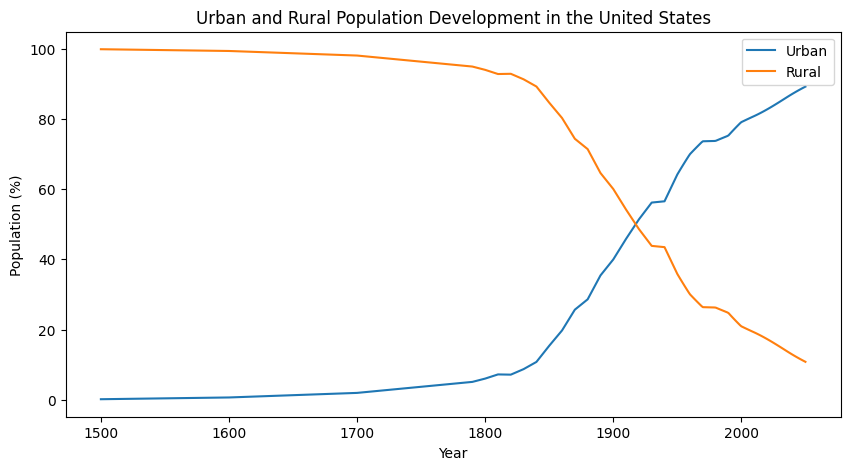

[{'role': 'system',
  'content': "\nYou are a data analyst, you will have a code execution tool, you need to write a python script, the tool will execute your content and return the results, now please analyze my csv file.\nI will provide you with some information about the csv, which is as follows:\n{\n     info: Changes in the urban-rural population ratio in major regions of the world from 1500 to 2050. The csv contains five columns, namely\n     column info: Entity,Code,Year, Urban population (%) long-run with 2050 projections (OWID),Rural population (%) long-run with 2050 projections (OWID)\n     path : 'data/urban-rural-population.csv'\n}\nEach column has some data, which you need to read through python code.\nNow, please follow my requirements, write the code appropriately, and analyze my csv file.\nI will provide you with the code to execute the tool, you just need to write the code according to my requirements.\nAll answers must be provided after querying the csv I provided. Yo

In [6]:
extract_function_and_execute(llm_output=response,messages=messages)

Question: From 1972 to 2048, did more people in Russia live in cities or in rural areas? What is the rate of growth or decline, and when is the fastest growth or decline?
Try 1 times
Final answer for question: From 1972 to 2048, did more people in Russia live in cities or in rural areas? What is the rate of growth or decline, and when is the fastest growth or decline?
Based on the analysis of the CSV file provided, from 1972 to 2048, the urban population in Russia grew at a faster rate than the rural population. The rate of growth or decline in the population difference between cities and rural areas is approximately 1.97% per year. The fastest growth or decline was observed in the year 1994.
Question: Please draw the distribution of urban and rural population proportions in 2023 and 2030 for all the countries in the table, and summarize the trends.


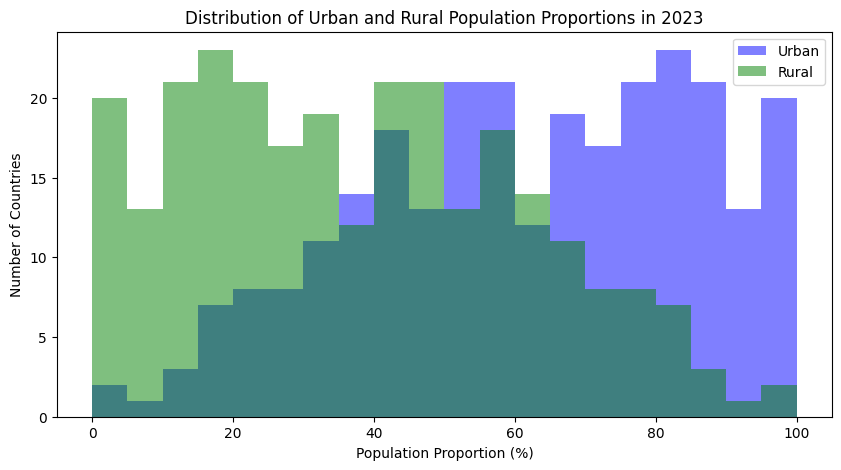

Try 1 times


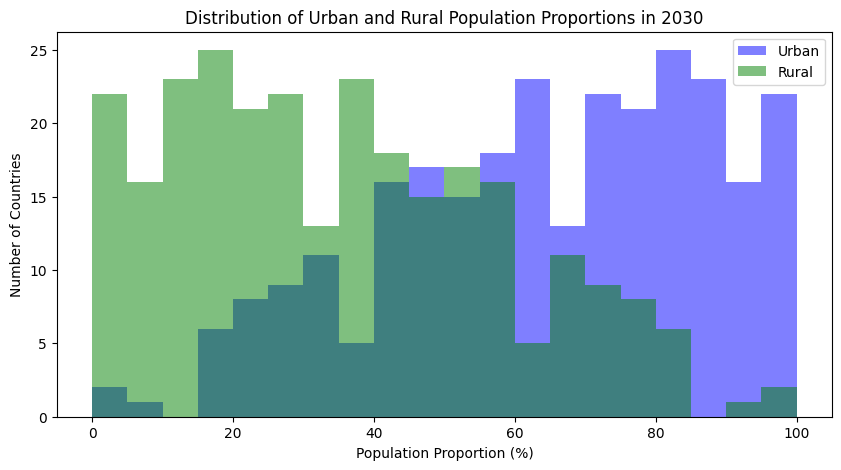

Final answer for question: Please draw the distribution of urban and rural population proportions in 2023 and 2030 for all the countries in the table, and summarize the trends.
Based on the analysis of the urban-rural population csv file, the distribution of urban and rural population proportions in 2023 and 2030 has been visualized using histograms. The trends observed indicate that, on average, the urban population proportion has increased by 2.29% between 2023 and 2030, while the rural population proportion has correspondingly decreased by -2.29%. This suggests a continuing shift from rural to urban living patterns globally.
Question: Compare the average growth rate of urbanized population in 'Colombia,Luxembourg and Macao' and draw a bar chart to tell me which country has the fastest growing proportion of urban population
Try 1 times
traceback: An error occurred: unexpected character after line continuation character (<string>, line 25)


<string>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


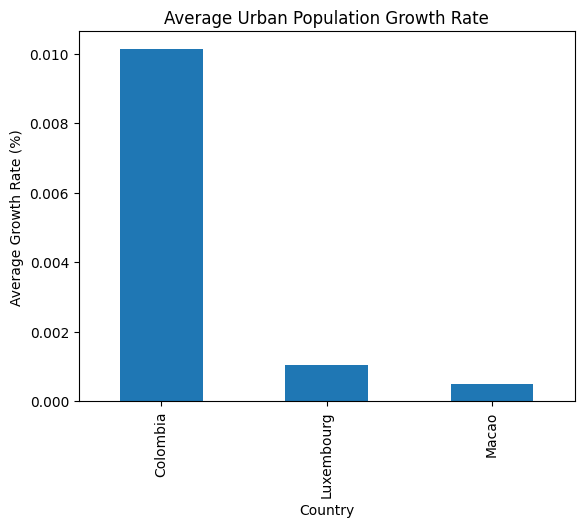

Try 2 times
Final answer for question: Compare the average growth rate of urbanized population in 'Colombia,Luxembourg and Macao' and draw a bar chart to tell me which country has the fastest growing proportion of urban population
The code has executed successfully. The bar chart showing the average urban population growth rate for Colombia, Luxembourg, and Macao has been displayed. Please check the chart to determine which country has the fastest growing proportion of urban population.


In [9]:
questions = [
    "From 1972 to 2048, did more people in Russia live in cities or in rural areas? What is the rate of growth or decline, and when is the fastest growth or decline?",
    "Please draw the distribution of urban and rural population proportions in 2023 and 2030 for all the countries in the table, and summarize the trends.",
    "Compare the average growth rate of urbanized population in 'Colombia,Luxembourg and Macao' and draw a bar chart to tell me which country has the fastest growing proportion of urban population"
]

for question in questions:
    print("=========================")
    print("Question:",question)
    messages=[
        {
            "role":"system",
            "content":sys_prompt
        },
        {
            "role":"user",
            "content":question
        }
    ]

    number_try=0

    while True:
        response=client.chat.completions.create(
            model='glm-4',
            messages=messages,
            top_p=0.1,
            tools=tools,
            temperature=0.1,
            max_tokens=2000
        )

        if response.choices[0].finish_reason=="stop":
            print("Final answer for question:",question)
            print(response.choices[0].message.content)
            break
        elif response.choices[0].finish_reason=="tool_calls":
            number_try+=1
            if number_try>10:
                print("Too many attempts,automatic stop for question:",question)
                break
            else:
                print(f"Try {number_try} times")
                print("==========================")
            messages.append({
                "role": response.choices[0].message.role,
                "tool_calls":[
                    {
                        "id":response.choices[0].message.tool_calls[0].id,
                        "type":"function",
                        "index":0,
                        "function":{
                                "arguments": response.choices[0].message.tool_calls[0].function.arguments,
                                "name": response.choices[0].message.tool_calls[0].function.name
                        }
                    }
                ]
            })
            extract_function_and_execute(llm_output=response,messages=messages)